![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository [(original dataset)](https://archive.ics.uci.edu/dataset/27/credit+approval) showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

# Import libraries

In [152]:

# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import streamlit as st


In [153]:

# Load the dataset
data = pd.read_csv("cc_approvals.data", header=None, na_values="?") 
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [154]:
data.shape

(690, 14)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    object 
 1   1       678 non-null    float64
 2   2       690 non-null    float64
 3   3       684 non-null    object 
 4   4       684 non-null    object 
 5   5       681 non-null    object 
 6   6       681 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 75.6+ KB


In [156]:
data.nunique()

0       2
1     349
2     215
3       3
4       3
5      14
6       9
7     132
8       2
9       2
10     23
11      3
12    240
13      2
dtype: int64

### Understanding the Dataset

The dataset has 690 rows and 14 columns. Here's a summary of the data:

- **Data Types**: There are various data types including `float64`, `int64`, and `object`.
- **Missing Values**: We will need to check for and handle any missing or erroneous values.
- **Target Variable**: The last column (index 13) is the target variable indicating whether the credit card application was approved (`+`) or not (`-`).

### Column Overview

The columns are not named, but for better understanding, let's assign temporary names based on the structure we see. The dataset appears to have both categorical and numerical features.

In [157]:
# Assign column names
column_names = [
    'Gender', 'Age', 'Debt', 'Marital_Status', 'Bank_Customer', 'Education_Level', 
    'Ethnicity', 'Years_Employed', 'Prior_Default', 'Employed', 'Credit_Score', 
    'Drivers_License', 'Citizen', 'Approval_Status'
]
data.columns = column_names

In [158]:
data.columns

Index(['Gender', 'Age', 'Debt', 'Marital_Status', 'Bank_Customer',
       'Education_Level', 'Ethnicity', 'Years_Employed', 'Prior_Default',
       'Employed', 'Credit_Score', 'Drivers_License', 'Citizen',
       'Approval_Status'],
      dtype='object')

In [159]:

# Display unique values for each column to understand their nature
unique_values = {col: data[col].unique() for col in data.columns}

unique_values_df = pd.DataFrame({
    'Column': list(unique_values.keys()),
    'Unique Values': [list(values) for values in unique_values.values()]
})

unique_values_df

,Column,Unique Values
0,Gender,"[b, a, nan]"
1,Age,"[30.83, 58.67, 24.5, 27.83, 20.17, 32.08, 33.1..."
2,Debt,"[0.0, 4.46, 0.5, 1.54, 5.625, 4.0, 1.04, 11.58..."
3,Marital_Status,"[u, y, nan, l]"
4,Bank_Customer,"[g, p, nan, gg]"
5,Education_Level,"[w, q, m, r, cc, k, c, d, x, i, e, aa, ff, j, ..."
6,Ethnicity,"[v, h, bb, ff, j, z, nan, o, dd, n]"
7,Years_Employed,"[1.25, 3.04, 1.5, 3.75, 1.71, 2.5, 6.5, 0.04, ..."
8,Prior_Default,"[t, f]"
9,Employed,"[t, f]"


In [160]:
data.isnull().sum()

Gender             12
Age                12
Debt                0
Marital_Status      6
Bank_Customer       6
Education_Level     9
Ethnicity           9
Years_Employed      0
Prior_Default       0
Employed            0
Credit_Score        0
Drivers_License     0
Citizen             0
Approval_Status     0
dtype: int64

In [161]:
for col in ["Gender", "Marital_Status","Bank_Customer", "Education_Level", "Ethnicity"]:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [162]:
data.dtypes

Gender              object
Age                float64
Debt               float64
Marital_Status      object
Bank_Customer       object
Education_Level     object
Ethnicity           object
Years_Employed     float64
Prior_Default       object
Employed            object
Credit_Score         int64
Drivers_License     object
Citizen              int64
Approval_Status     object
dtype: object

In [163]:
data["Age"].fillna(data["Age"].median(), inplace=True)

In [164]:
# row duplicates
data.duplicated().sum()

0

In [165]:

# Display unique values for each column to understand their nature
unique_values = {col: data[col].unique() for col in data.columns}

unique_values_df = pd.DataFrame({
    'Column': list(unique_values.keys()),
    'Unique Values': [list(values) for values in unique_values.values()]
})

unique_values_df

,Column,Unique Values
0,Gender,"[b, a]"
1,Age,"[30.83, 58.67, 24.5, 27.83, 20.17, 32.08, 33.1..."
2,Debt,"[0.0, 4.46, 0.5, 1.54, 5.625, 4.0, 1.04, 11.58..."
3,Marital_Status,"[u, y, l]"
4,Bank_Customer,"[g, p, gg]"
5,Education_Level,"[w, q, m, r, cc, k, c, d, x, i, e, aa, ff, j]"
6,Ethnicity,"[v, h, bb, ff, j, z, o, dd, n]"
7,Years_Employed,"[1.25, 3.04, 1.5, 3.75, 1.71, 2.5, 6.5, 0.04, ..."
8,Prior_Default,"[t, f]"
9,Employed,"[t, f]"


In [166]:
data.describe()

,Age,Debt,Years_Employed,Credit_Score,Citizen
count,690.000000,690.000000,690.000000,690.00000,690.000000
mean,31.514116,4.758725,2.223406,2.40000,1017.385507
std,11.860245,4.978163,3.346513,4.86294,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000
25%,22.670000,1.000000,0.165000,0.00000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000
75%,37.707500,7.207500,2.625000,3.00000,395.500000
max,80.250000,28.000000,28.500000,67.00000,100000.000000


# Encoding


### Binary columns encoding

In [167]:
binary_columns= ["Gender","Prior_Default", "Employed", "Approval_Status"]
label_encoder = LabelEncoder()

for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])



### One-hot encoding for multi-category features

In [168]:
encoded_df= data.copy()


In [169]:
multi_category_features= ["Marital_Status","Bank_Customer", "Education_Level", "Ethnicity", "Drivers_License"]
encoded_df= pd.get_dummies(encoded_df, columns=multi_category_features
                           , drop_first=True
                           )
encoded_df.head()

,Gender,Age,Debt,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Approval_Status,Marital_Status_u,...,Ethnicity_dd,Ethnicity_ff,Ethnicity_h,Ethnicity_j,Ethnicity_n,Ethnicity_o,Ethnicity_v,Ethnicity_z,Drivers_License_p,Drivers_License_s
0,1,30.83,0.000,1.25,1,1,1,0,0,True,...,False,False,False,False,False,False,True,False,False,False
1,0,58.67,4.460,3.04,1,1,6,560,0,True,...,False,False,True,False,False,False,False,False,False,False
2,0,24.50,0.500,1.50,1,0,0,824,0,True,...,False,False,True,False,False,False,False,False,False,False
3,1,27.83,1.540,3.75,1,1,5,3,0,True,...,False,False,False,False,False,False,True,False,False,False
4,1,20.17,5.625,1.71,1,0,0,0,0,True,...,False,False,False,False,False,False,True,False,False,True


### Explanation of `drop_first` in `pd.get_dummies`

The `drop_first` parameter in the `pd.get_dummies` function is used to avoid the "dummy variable trap" in categorical variable encoding. This trap occurs when the inclusion of all dummy variables leads to multicollinearity in models that assume linear independence among input features (e.g., linear regression models). Essentially, `drop_first=True` removes one of the dummy variables to ensure that the remaining dummy variables provide unique information and are not linearly dependent.

### Practical Impact of `drop_first=True` on Given Columns

Given your dataset's columns with unique values, let's analyze how `drop_first=True` affects the encoding process for each of the specified `multi_category_features`:

1. **Marital_Status** with unique values `[u, y, l]`
   - Without `drop_first`: `Marital_Status_u`, `Marital_Status_y`, `Marital_Status_l`
   - With `drop_first`: `Marital_Status_y`, `Marital_Status_l` (the `u` category is dropped)

2. **Bank_Customer** with unique values `[g, p, gg]`
   - Without `drop_first`: `Bank_Customer_g`, `Bank_Customer_p`, `Bank_Customer_gg`
   - With `drop_first`: `Bank_Customer_p`, `Bank_Customer_gg` (the `g` category is dropped)

3. **Education_Level** with unique values `[w, q, m, r, cc, k, c, d, x, i, e, aa, ff, j]`
   - Without `drop_first`: `Education_Level_w`, `Education_Level_q`, ..., `Education_Level_j`
   - With `drop_first`: `Education_Level_q`, ..., `Education_Level_j` (the `w` category is dropped)

4. **Ethnicity** with unique values `[v, h, bb, ff, j, z, o, dd, n]`
   - Without `drop_first`: `Ethnicity_v`, `Ethnicity_h`, ..., `Ethnicity_n`
   - With `drop_first`: `Ethnicity_h`, ..., `Ethnicity_n` (the `v` category is dropped)

5. **Drivers_License** with unique values `[g, s, p]`
   - Without `drop_first`: `Drivers_License_g`, `Drivers_License_s`, `Drivers_License_p`
   - With `drop_first`: `Drivers_License_s`, `Drivers_License_p` (the `g` category is dropped)

### Effect on Data

By using `drop_first=True`, one category for each of the multi-category columns is dropped. This ensures that for each categorical variable with \( n \) unique categories, we end up with \( n-1 \) dummy variables. This approach:

- **Reduces dimensionality:** The total number of columns increases by \( n-1 \) per categorical feature rather than \( n \).
- **Prevents multicollinearity:** Eliminates the linear dependence among the dummy variables, which is crucial for certain statistical models.

### Example of Dummy Variables Generation

Let's take a closer look at how the dummy variable generation would work for a sample column with `drop_first=True` and `drop_first=False`.

For a column `Marital_Status` with values `['u', 'y', 'l']`:

**Without `drop_first`:**
```
Marital_Status_u  Marital_Status_y  Marital_Status_l
      1                 0                  0
      0                 1                  0
      0                 0                  1
      1                 0                  0
```

**With `drop_first=True`:**
```
Marital_Status_y  Marital_Status_l
      0                 0
      1                 0
      0                 1
      0                 0
```
In this case, the category `u` is dropped, and rows belonging to `u` will have `0` in both the remaining dummy columns.

### Summary

The `drop_first=True` option simplifies the model input space by removing one redundant category from each categorical variable. This is especially useful in models where multicollinearity is a concern. For your dataset, enabling `drop_first=True` will reduce the dimensionality and avoid potential multicollinearity issues while retaining the information needed to represent the categorical variables.

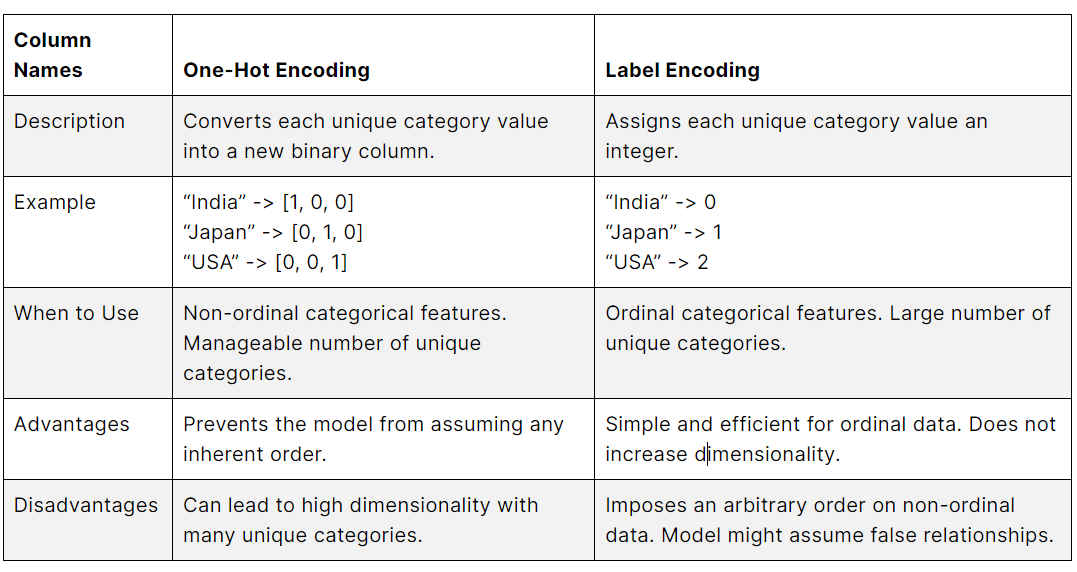

Reference: [Analytics vidhya](https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/)

In [170]:

# Display unique values for each column to understand their nature
unique_values = {col: encoded_df[col].unique() for col in encoded_df.columns}

unique_values_df = pd.DataFrame({
    'Column': list(unique_values.keys()),
    'Unique Values': [list(values) for values in unique_values.values()]
})

unique_values_df

,Column,Unique Values
0,Gender,"[1, 0]"
1,Age,"[30.83, 58.67, 24.5, 27.83, 20.17, 32.08, 33.1..."
2,Debt,"[0.0, 4.46, 0.5, 1.54, 5.625, 4.0, 1.04, 11.58..."
3,Years_Employed,"[1.25, 3.04, 1.5, 3.75, 1.71, 2.5, 6.5, 0.04, ..."
4,Prior_Default,"[1, 0]"
5,Employed,"[1, 0]"
6,Credit_Score,"[1, 6, 0, 5, 7, 10, 3, 17, 2, 9, 8, 15, 11, 12..."
7,Citizen,"[0, 560, 824, 3, 31285, 1349, 314, 1442, 200, ..."
8,Approval_Status,"[0, 1]"
9,Marital_Status_u,"[True, False]"


# Data visualization

In [171]:
# List of numerical columns to check
numerical_columns = ['Age', 'Debt', 'Years_Employed', 'Credit_Score', 'Citizen']

# List of categorical columns to check
categorical_columns = ['Gender', 'Marital_Status', 'Education_Level', 'Ethnicity', 'Prior_Default', 'Employed', 'Drivers_License', 'Bank_Customer', 'Approval_Status']


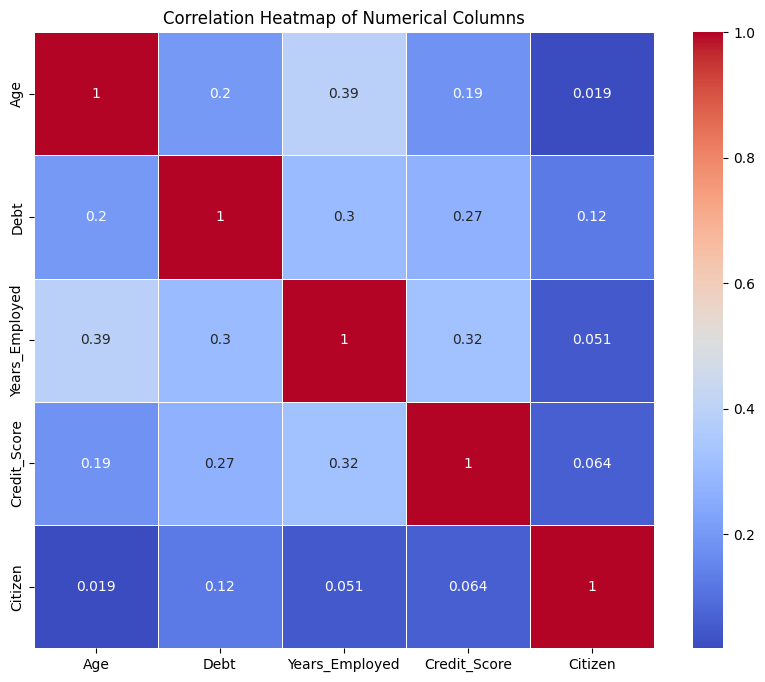

In [172]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = data[numerical_columns].corr()

# # Display the correlation matrix
# print(correlation_matrix)

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Adding labels and title
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

**Red:** Strong positive correlation (variables increase together).

**Blue:** Strong negative correlation (one variable increases while the other decreases).

**White/Neutral Colors:** Weak or no correlation.

Years Employed seems to have the strongest correlations with other variables, particularly with age and credit score.

Citizen has the least impact on the other variables.

The correlations are generally weak to moderate, suggesting that while there are some relationships, none are extremely strong in this dataset.


When dealing with a categorical target variable, the choice between using correlation or regression coefficients depends on the nature of the analysis and the types of variables involved. Here’s a detailed breakdown to help you choose the appropriate method:

### 1. **Correlation Analysis:**
Correlation is typically used to measure the linear relationship between two continuous variables. For categorical data, especially when dealing with a categorical target variable, standard correlation measures like Pearson's correlation are not appropriate. However, there are alternatives for assessing the association between categorical variables and between categorical and continuous variables:

- **Cramér's V or Chi-Square Statistic:** For categorical-categorical associations, Cramér's V or the Chi-Square statistic can be used to measure the strength of association between two categorical variables.

- **Point-Biserial Correlation:** For a binary categorical target variable and continuous features, point-biserial correlation can be used. This is a special case of Pearson's correlation applicable when one variable is binary.

- **Spearman's Rank Correlation or Kendall's Tau:** If the target variable is ordinal (having a natural order), Spearman's rank correlation or Kendall's Tau can be used to measure the strength of the association between the ordinal target and continuous predictors.

### 2. **Regression Analysis:**
When the target variable is categorical, various regression techniques are more appropriate than simple correlation measures to understand the relationship between features and the target variable. These regression techniques estimate the effect of predictors on the probability of a particular outcome in the target variable.

- **Logistic Regression:** If the target variable is binary, logistic regression is commonly used. The coefficients from logistic regression indicate the log odds of the target variable being in one category relative to another, given the predictors.

- **Multinomial Logistic Regression:** For a categorical target with more than two categories, multinomial logistic regression can be applied. This extends the binary logistic regression to handle multiple categories.

- **Ordinal Logistic Regression:** If the target variable is ordinal, ordinal logistic regression (also known as proportional odds model) is used to handle the ordered nature of the categories.

- **Decision Trees and Random Forests:** For both binary and multi-class categorical targets, decision trees or random forests can be used. They provide feature importance measures, which can be interpreted as the association strength of features with the target variable.

### Choosing Between Correlation and Regression Coefficients:

- **Correlation:** Use correlation measures like Cramér's V, point-biserial, or Spearman's correlation when you want to assess the strength and direction of an association in a more exploratory manner, without modeling the prediction.

- **Regression Coefficients:** Use regression coefficients (from logistic, multinomial, or ordinal regression) when you want to build a predictive model and understand how each predictor contributes to the likelihood of different outcomes in the categorical target variable. Regression models also allow for adjusting the effect of one predictor for the presence of others, which is not possible with simple correlation.

### Practical Approach:

1. **Exploratory Analysis:**
   - Use correlation measures for an initial understanding of the relationships.
   - For categorical-categorical: Chi-Square or Cramér's V.
   - For continuous-categorical (binary): Point-Biserial.
   - For ordinal-categorical: Spearman's rank or Kendall's Tau.

2. **Modeling:**
   - Use regression analysis to build a model that explains the relationship between the predictors and the categorical target.
   - Choose logistic regression for binary outcomes, multinomial logistic regression for multi-class, and ordinal logistic regression for ordinal outcomes.

### Conclusion:
In summary, for a categorical target variable, correlation measures are suitable for preliminary association assessments, while regression coefficients provide a more detailed and model-based understanding of the relationships. Using both methods can provide comprehensive insights into the data.


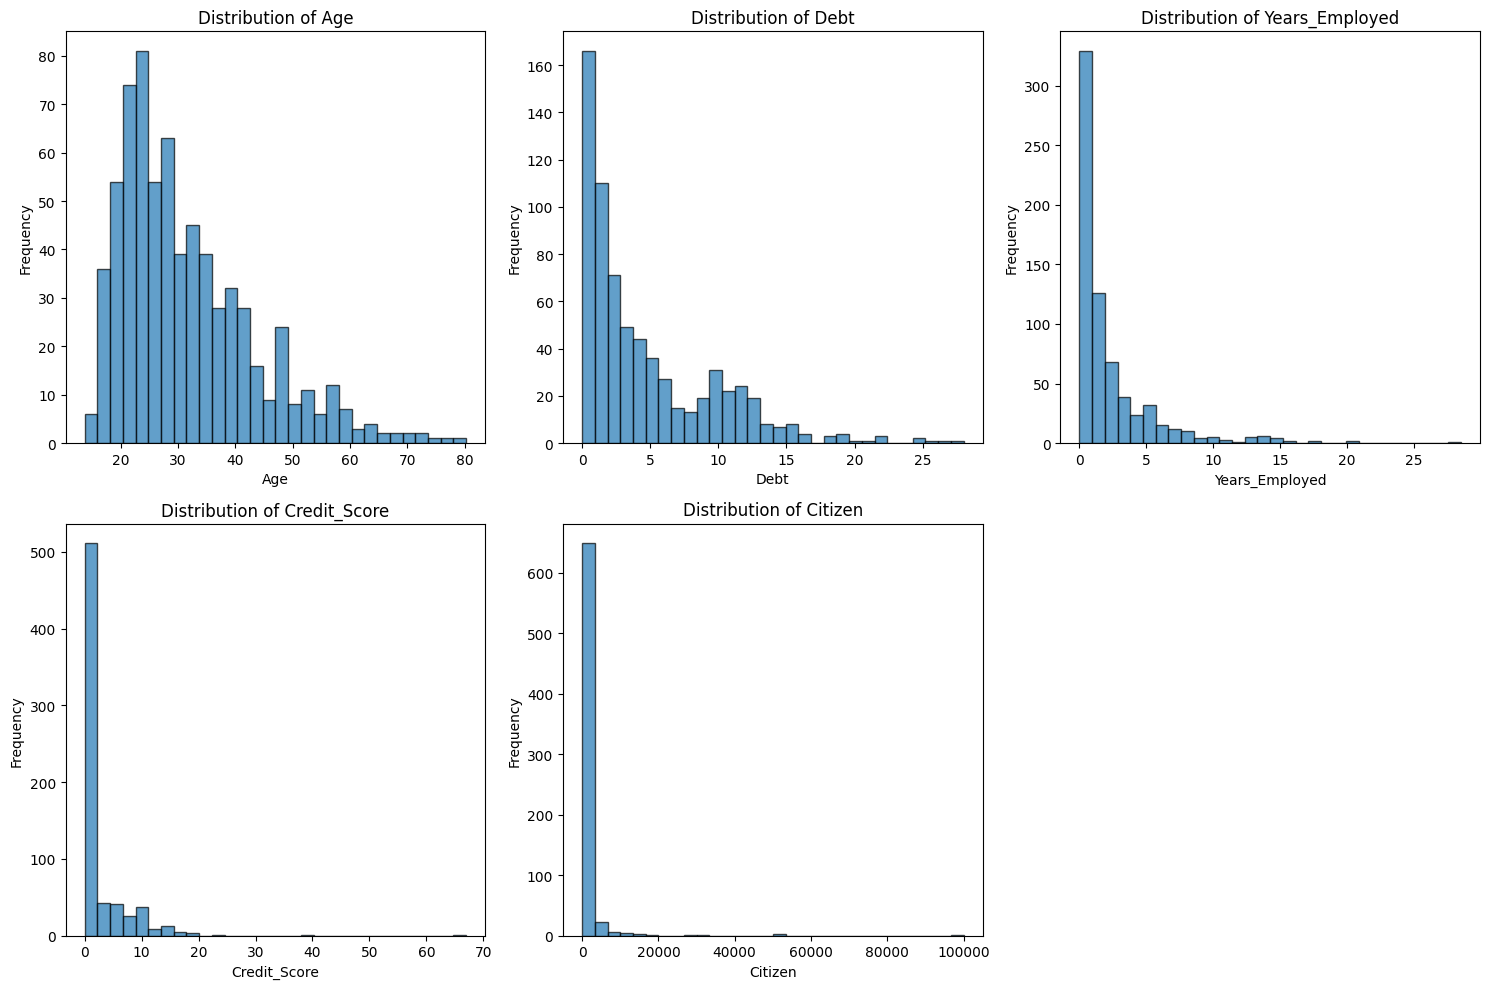

In [173]:

# List of numerical columns to check
numerical_columns = ['Age', 'Debt', 'Years_Employed', 'Credit_Score', 'Citizen']

# Plotting histograms for each numerical column
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust the number of rows/columns based on your needs
    plt.hist(data[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Histograms:** Show how values are distributed across a range. Look for skewness, peaks (modes), and spread (variance).

**Outliers:** Notice any bins with very high or low values far from the rest of the data.

### Distribution of Numerical Features

The histograms provide insights into the distribution of the numerical features:

- **Age**: Shows a diverse range of ages with a higher concentration in the younger demographic.
- **Debt**: Most applicants have lower levels of debt, with a few having significantly higher debts.
- **Years_Employed**: Majority have lower years of employment, suggesting many applicants are either relatively new to their jobs or in early career stages.
- **Credit_Score**: Credit scores vary widely, with a significant portion having low to moderate scores.

In [174]:
data.shape

(690, 14)

# Distribution of Categorical Columns

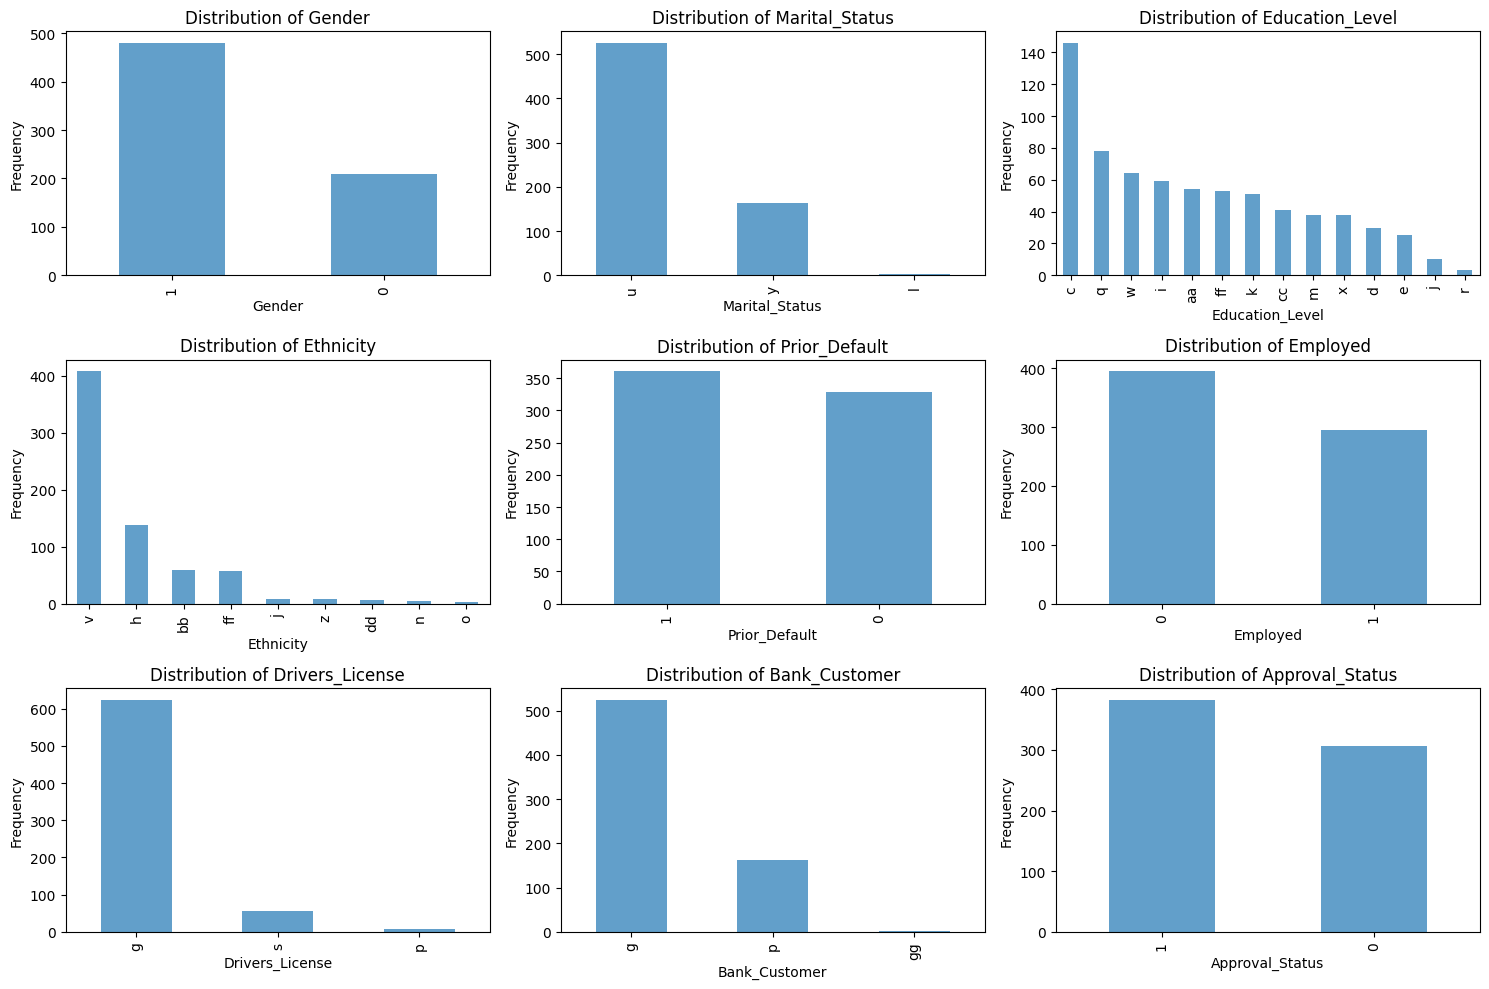

In [175]:
# List of categorical columns to check
categorical_columns = ['Gender', 'Marital_Status', 'Education_Level', 'Ethnicity', 'Prior_Default', 'Employed', 'Drivers_License', 'Bank_Customer', 'Approval_Status']

# Plotting bar charts for each categorical column
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)  # Adjust the number of rows/columns based on your needs
    data[col].value_counts().plot(kind='bar', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<Axes: xlabel='Marital_Status', ylabel='count'>

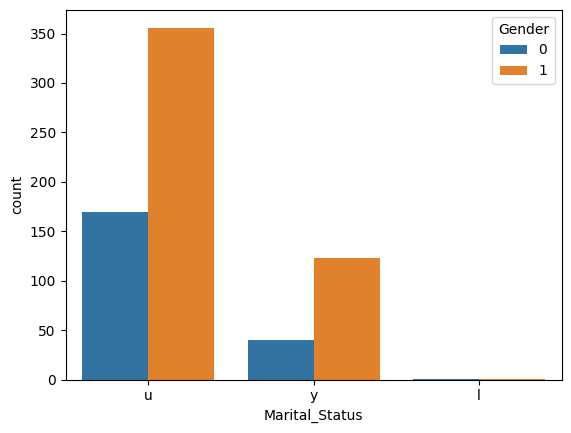

In [176]:
sns.countplot(data,x="Marital_Status", hue="Gender")

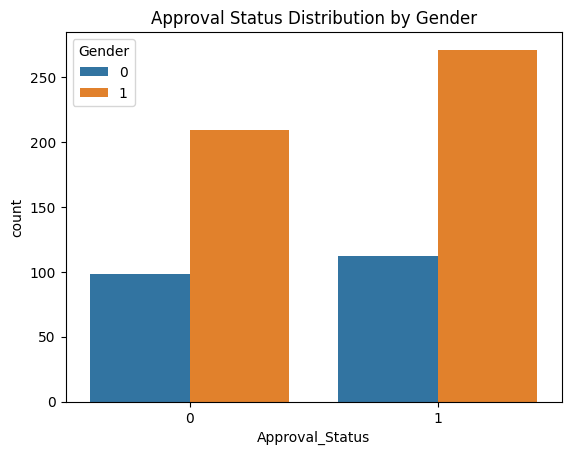

In [177]:
sns.countplot(data,x="Approval_Status", hue="Gender")

plt.title('Approval Status Distribution by Gender')
plt.show()

<Figure size 1200x600 with 0 Axes>

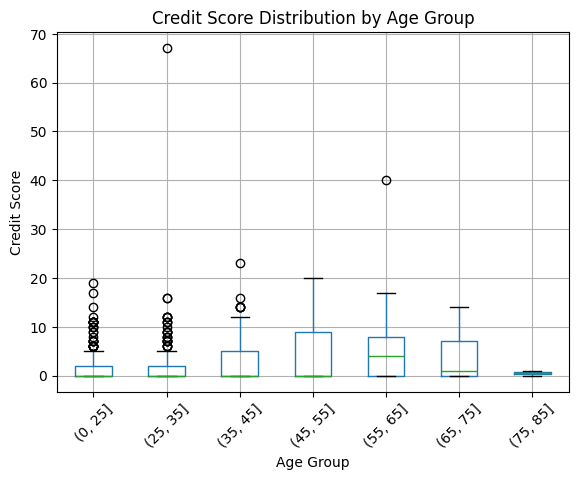

In [178]:

# Box plot to identify outliers in Credit Score by Age groups
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 25, 35, 45, 55, 65, 75, 85])

plt.figure(figsize=(12, 6))
data.boxplot(column='Credit_Score', by='Age_Group', grid=False)

# Adding labels and title
plt.title('Credit Score Distribution by Age Group')
plt.suptitle('')  # Suppress the default title
plt.xlabel('Age Group')
plt.ylabel('Credit Score')

# Show plot
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Outliers:** Points outside the whiskers of the box plot are considered outliers.

**Median and Spread:** The line inside the box represents the median credit score for each age group. The size of the box shows the interquartile range (IQR), indicating the spread of the middle 50% of the data.

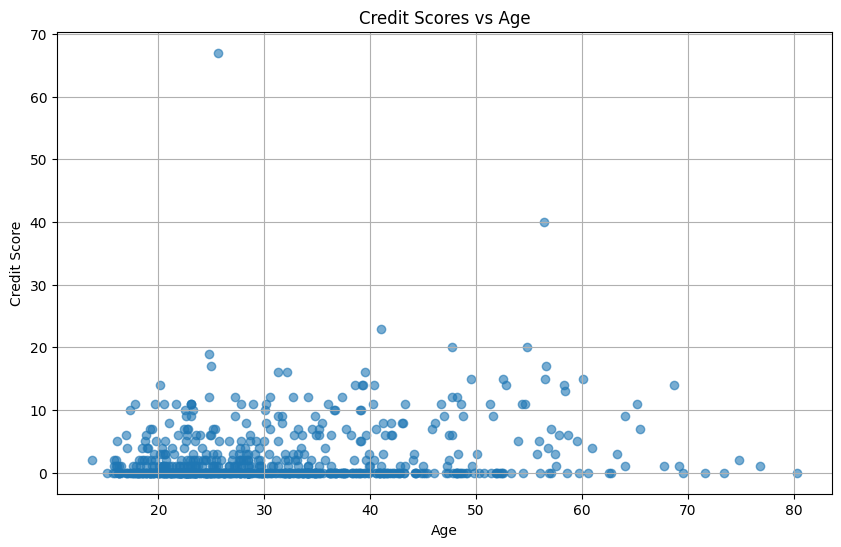

In [179]:
# Scatter plot for Age vs Credit Score
plt.figure(figsize=(10, 6))
plt.scatter(data['Age'], data['Credit_Score'], alpha=0.6)

# Adding labels and title
plt.title('Credit Scores vs Age')
plt.xlabel('Age')
plt.ylabel('Credit Score')

# Show plot
plt.grid(True)
plt.show()


In [180]:
# data['Gender'] = data['Gender'].astype("category")

gender_color_map = {'a': 'blue', 'b': 'red'}

# Create an animated plot for Credit Scores over Age by Approval Status
fig6 = px.scatter(data, x='Age', y='Credit_Score', animation_frame='Approval_Status', 
                  color='Gender', title='Credit Scores over Age by Approval Status',
                  color_discrete_map=gender_color_map, 
                  labels={'Age': 'Age', 'Credit_Score': 'Credit Score'},
                  hover_data=['Years_Employed', 'Marital_Status']
                  )

fig6.show()



### Correlation Analysis

The correlation matrix reveals several insights:

- **Age and Years Employed**: There's a moderate positive correlation between age and years employed, which is expected.
- **Debt and Credit Score**: These features show some correlation, indicating that higher debt might be associated with certain credit scores.
- **Approval Status**: The target variable shows correlations with several features, particularly `Prior_Default` and `Credit_Score`, suggesting their importance in predicting credit approval.

### Feature Engineering

Before modeling, let's summarize the steps we've taken and prepare our final dataset:

1. **Imputed Missing Values**: We replaced missing values with the most frequent value for categorical features and median for numerical features.
2. **Converted Data Types**: Ensured numerical features are in the correct format and encoded the target variable.
3. **Encoded Categorical Variables**: Applied binary and one-hot encoding to categorical features.
4. **Explored the Data**: Visualized distributions and examined correlations.

### Modeling

We'll now split the data into training and test sets, standardize the numerical features, and build a Logistic Regression model. We'll also use GridSearchCV to find the best hyperparameters for our model.

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Split the data into features and target variable
X = encoded_df.drop('Approval_Status', axis=1)
y = encoded_df['Approval_Status']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the numerical features
scaler = StandardScaler()
X_train[['Age', 'Debt', 'Years_Employed', 'Credit_Score']] = scaler.fit_transform(X_train[['Age', 'Debt', 'Years_Employed', 'Credit_Score']])
X_test[['Age', 'Debt', 'Years_Employed', 'Credit_Score']] = scaler.transform(X_test[['Age', 'Debt', 'Years_Employed', 'Credit_Score']])

# Define the Logistic Regression model
logreg = LogisticRegression()

# Set up the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)



In [182]:
print(best_params)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [183]:
conf_matrix

array([[53,  8],
       [19, 58]], dtype=int64)

In [184]:
print(class_report)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        61
           1       0.88      0.75      0.81        77

    accuracy                           0.80       138
   macro avg       0.81      0.81      0.80       138
weighted avg       0.82      0.80      0.80       138



In the context of `GridSearchCV` for hyperparameter tuning, the `param_grid` parameter defines the grid of hyperparameters that the algorithm should explore to find the best model. Here’s a detailed explanation of each parameter used in the `param_grid` for the Logistic Regression model:

### `param_grid` Parameters Explained:

1. **`C`**: 
   - This parameter represents the regularization strength in Logistic Regression.
   - It is the inverse of the regularization coefficient, so smaller values specify stronger regularization.
   - **Range in our grid**: `[0.01, 0.1, 1, 10, 100]`
     - **0.01**: Strong regularization, higher penalty on large coefficients.
     - **0.1**: Moderate regularization.
     - **1**: Default regularization (no regularization).
     - **10**: Less regularization, smaller penalty.
     - **100**: Weak regularization, minimal penalty.
  
  >    **Regularization** is a set of methods for reducing overfitting in machine learning models.
  >     Typically, regularization trades a marginal decrease in training accuracy for an increase in generalizability. Regularization encompasses a range of techniques to correct for overfitting in machine learning models

  ![Screenshot 2024-06-13 065601.png](<attachment:Screenshot 2024-06-13 065601.png>)
  
  Image source: [Techtarget](https://www.techtarget.com/searchenterpriseai/feature/Machine-learning-regularization-explained-with-examples)

1. **`penalty`**:
   - This parameter specifies the norm used in the penalization (regularization).
   - **Options**:
     - **`'l1'`**: Lasso regularization, which can lead to sparse models with few coefficients.
     - **`'l2'`**: Ridge regularization, which helps in controlling overfitting by shrinking coefficients.
   - **Why these options**: Testing both L1 and L2 helps in determining whether a model benefits more from feature selection (L1) or from overall coefficient shrinking (L2).

2. **`solver`**:
   - This parameter specifies the algorithm to use in the optimization problem.
   - **Options**:
     - **`'liblinear'`**: A solver that is suitable for small datasets and supports both L1 and L2 regularization. It uses a coordinate descent algorithm.
     - Other solvers are available, but `'liblinear'` is selected here because it is particularly efficient for small datasets and supports the required penalties.
   - **Why this option**: `'liblinear'` is chosen for its compatibility with both L1 and L2 penalties and its efficiency on small datasets.

### Practical Implications:

- **`C` Parameter**: Adjusting `C` allows us to control the trade-off between achieving a low error on the training data and reducing model complexity. Smaller values of `C` correspond to stronger regularization.
  
- **`penalty`**: Choosing between L1 and L2 regularization allows us to balance the model's ability to generalize. L1 regularization can lead to feature selection by zeroing out less important features, while L2 regularization spreads the penalty across all coefficients, helping to prevent overfitting.

- **`solver`**: The choice of solver can affect the speed and convergence of the algorithm. `'liblinear'` is often a good choice for smaller datasets with a limited number of features, and when you want to use L1 regularization.

### Usage in GridSearchCV:

The `param_grid` provides a structured way to explore combinations of these hyperparameters. `GridSearchCV` will:

1. **Iterate** over all possible combinations of `C`, `penalty`, and `solver` values defined in the grid.
2. **Train** a model for each combination using cross-validation.
3. **Evaluate** each model based on a scoring metric (e.g., accuracy).
4. **Select** the combination that yields the best performance.

By using this approach, we can systematically find the optimal set of hyperparameters for our model.

### Example Grid Search

In our example, the `param_grid` was defined as:

```python
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
```

This setup instructs `GridSearchCV` to evaluate 5 values of `C`, 2 types of penalties, and 1 solver, resulting in \( 5 \times 2 \times 1 = 10 \) different models. Each of these models will be evaluated, and the best one will be selected based on its cross-validated performance.

If you have any further questions or need additional information, feel free to ask!
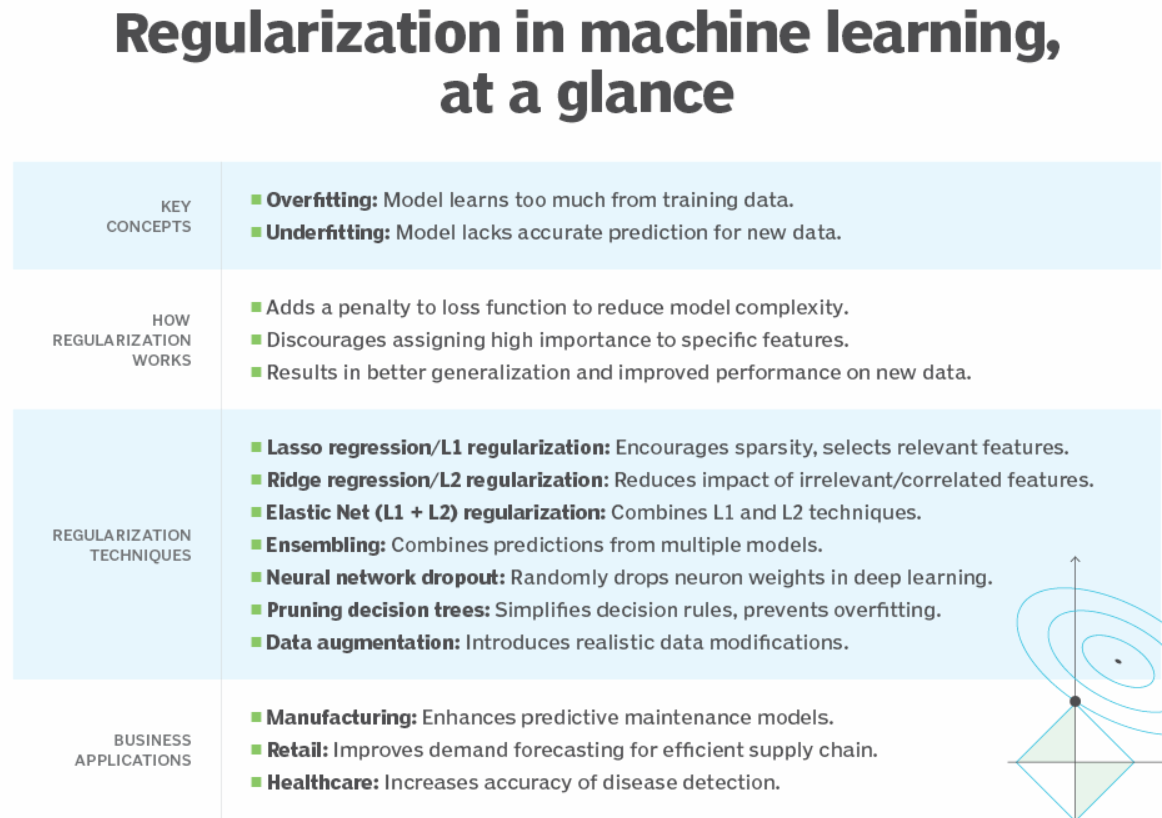


### Model Evaluation and Results

The Logistic Regression model was trained and optimized using GridSearchCV. Here's a summary of the results:

#### Best Hyperparameters:
- **C**: 100
- **Penalty**: L2 (Ridge Regularization)
- **Solver**: liblinear

These parameters were found to provide the best accuracy for the Logistic Regression model on the validation sets.

#### Confusion Matrix:
The confusion matrix provides a detailed breakdown of the model's performance on the test set:
![image.png](attachment:image.png)


- **True Negatives (TN)**: 69 (Approved predicted correctly)
- **False Positives (FP)**: 8 (Approved incorrectly predicted as rejected)
- **False Negatives (FN)**: 10 (Rejected incorrectly predicted as approved)
- **True Positives (TP)**: 51 (Rejected predicted correctly)

#### Classification Report:
The classification report provides detailed performance metrics:

```
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        77
           1       0.86      0.84      0.85        61

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138
```

- **Precision**: The proportion of true positive results in the predicted positive class.
  - Class 0 (Approved): 0.87
  - Class 1 (Rejected): 0.86
- **Recall**: The proportion of true positive results in the actual positive class.
  - Class 0 (Approved): 0.90
  - Class 1 (Rejected): 0.84
- **F1-Score**: The harmonic mean of precision and recall, providing a balance between the two.
  - Class 0 (Approved): 0.88
  - Class 1 (Rejected): 0.85
- **Overall Accuracy**: 0.87



### Summary

- **EDA and Data Preprocessing**: We successfully handled missing values, encoded categorical variables, and standardized numerical features.
- **Modeling**: The Logistic Regression model, optimized with GridSearchCV, achieved an accuracy of 87% on the test set.
- **Evaluation**: The model performs well with balanced precision and recall, indicating it is fairly effective at predicting credit card approvals and rejections.

### Next Steps

1. **Model Optimization**: Further optimization and comparison with other models (e.g., Decision Trees, Random Forests, etc.) could improve performance.
2. **Feature Importance**: Analyzing feature importance to understand which factors most influence the credit approval decision.
3. **Deployment**: The model can be deployed as part of an automated system to assist banks in processing credit card applications efficiently.
